In [52]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np

In [53]:
final_df = pd.read_parquet("data/final/customers_features_target.parquet")  
final_df.head()

,Customer ID,recency,frequency,monetary,R,F,M,RFM_score,tenure_days,avg_order_value,purchase_velocity,avg_days_between_orders,churn_flag,discount_use_ratio,cohort_month,future_clv,future_clv_log,is_active_future
0,12346,326,48,-64.68,2,2,1,221,726.0,-1.347500,1.983471,15.125000,1,0.020833,2009-12,263.00,5.575949,1
1,12347,40,253,5633.32,3,4,4,344,516.0,22.266087,14.709302,2.039526,1,0.000000,2010-07,252.54,5.535522,1
2,12348,76,51,2019.40,3,2,3,323,439.0,39.596078,3.485194,8.607843,1,0.000000,2010-09,63.99,4.174233,1
3,12349,19,180,4404.54,4,4,4,444,972.0,24.469667,5.555556,5.400000,1,0.000000,2009-04,480.76,6.177446,1
4,12350,311,17,334.40,2,1,2,212,311.0,19.670588,1.639871,18.294118,1,0.000000,2011-02,0.00,0.000000,0


In [54]:
nonzero_ratio = (final_df['future_clv'] > 0).mean()
print(f"✅ Customers with future CLV > 0: {nonzero_ratio:.2%}")

✅ Customers with future CLV > 0: 58.43%


In [55]:
print("\n📊 Target (future_clv) summary:")
print(final_df['future_clv'].describe().to_string())


📊 Target (future_clv) summary:
count     5942.000000
mean       133.664445
std        583.917379
min          0.000000
25%          0.000000
50%         24.395000
75%        130.985000
max      26480.310000


In [56]:
skew_value = final_df['future_clv'].skew()
print(f"📈 Skewness: {skew_value:.2f}")

📈 Skewness: 28.05


In [57]:

print("\n🔍 Sample CLV values:")
print(final_df[['Customer ID', 'future_clv', 'future_clv_log']].sample(5, random_state=42))


🔍 Sample CLV values:
      Customer ID  future_clv  future_clv_log
4766        17112       98.82        4.603369
2131        14477        3.60        1.526056
1400        13746       31.17        3.471034
5183        17529      305.46        5.725087
2827        15173      124.49        4.832226


In [58]:
final_df['future_clv_log'] = np.log1p(final_df['future_clv'])


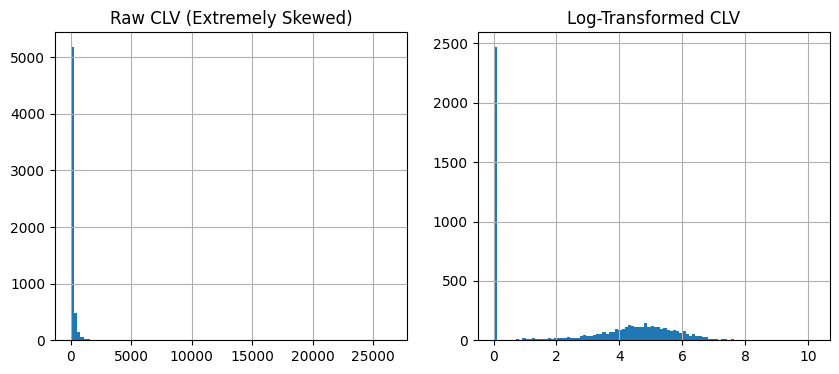

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
final_df['future_clv'].hist(bins=100)
plt.title('Raw CLV (Extremely Skewed)')

plt.subplot(1,2,2)
final_df['future_clv_log'].hist(bins=100)
plt.title('Log-Transformed CLV')
plt.show()


In [60]:
transactions_df = pd.read_csv("data/processed/cleaned_dataset.csv", parse_dates=['InvoiceDate'])

In [61]:
transactions_df['InvoiceDate'] = pd.to_datetime(transactions_df['InvoiceDate'])

In [62]:
future_txns = transactions_df[transactions_df['InvoiceDate'] >= '2010-07-01']
assert future_txns['InvoiceDate'].min() >= pd.Timestamp('2010-07-01')
print("✅ No leakage detected — target window correctly defined.")


✅ No leakage detected — target window correctly defined.


In [63]:
transactions_df['InvoiceDate'] = pd.to_datetime(transactions_df['InvoiceDate'])

cutoff_date = pd.Timestamp('2010-07-01')
future_txns = transactions_df[transactions_df['InvoiceDate'] >= cutoff_date]

print("Min:", transactions_df['InvoiceDate'].min())
print("Mafinal_df:", transactions_df['InvoiceDate'].max())
print("Future window:", future_txns['InvoiceDate'].min(), "→", future_txns['InvoiceDate'].max())


Min: 2009-01-12 07:45:00
Mafinal_df: 2011-12-10 17:19:00
Future window: 2010-07-01 09:34:00 → 2011-12-10 17:19:00


In [64]:
final_df.head()

,Customer ID,recency,frequency,monetary,R,F,M,RFM_score,tenure_days,avg_order_value,purchase_velocity,avg_days_between_orders,churn_flag,discount_use_ratio,cohort_month,future_clv,future_clv_log,is_active_future
0,12346,326,48,-64.68,2,2,1,221,726.0,-1.347500,1.983471,15.125000,1,0.020833,2009-12,263.00,5.575949,1
1,12347,40,253,5633.32,3,4,4,344,516.0,22.266087,14.709302,2.039526,1,0.000000,2010-07,252.54,5.535522,1
2,12348,76,51,2019.40,3,2,3,323,439.0,39.596078,3.485194,8.607843,1,0.000000,2010-09,63.99,4.174233,1
3,12349,19,180,4404.54,4,4,4,444,972.0,24.469667,5.555556,5.400000,1,0.000000,2009-04,480.76,6.177446,1
4,12350,311,17,334.40,2,1,2,212,311.0,19.670588,1.639871,18.294118,1,0.000000,2011-02,0.00,0.000000,0


In [65]:
final_df['is_active_future'] = (final_df['future_clv'] > 0).astype(int)


In [66]:
final_df['purchase_velocity'] = pd.to_numeric(final_df['purchase_velocity'], errors='coerce')
final_df['purchase_velocity'] = final_df['purchase_velocity'].replace([np.inf, -np.inf], np.nan)
final_df['purchase_velocity'] = final_df['purchase_velocity'].fillna(0)


In [67]:
final_df.head()

,Customer ID,recency,frequency,monetary,R,F,M,RFM_score,tenure_days,avg_order_value,purchase_velocity,avg_days_between_orders,churn_flag,discount_use_ratio,cohort_month,future_clv,future_clv_log,is_active_future
0,12346,326,48,-64.68,2,2,1,221,726.0,-1.347500,1.983471,15.125000,1,0.020833,2009-12,263.00,5.575949,1
1,12347,40,253,5633.32,3,4,4,344,516.0,22.266087,14.709302,2.039526,1,0.000000,2010-07,252.54,5.535522,1
2,12348,76,51,2019.40,3,2,3,323,439.0,39.596078,3.485194,8.607843,1,0.000000,2010-09,63.99,4.174233,1
3,12349,19,180,4404.54,4,4,4,444,972.0,24.469667,5.555556,5.400000,1,0.000000,2009-04,480.76,6.177446,1
4,12350,311,17,334.40,2,1,2,212,311.0,19.670588,1.639871,18.294118,1,0.000000,2011-02,0.00,0.000000,0


In [68]:
final_df['churn_flag'] = (final_df['churn_flag']).astype(int)
final_df.head()

,Customer ID,recency,frequency,monetary,R,F,M,RFM_score,tenure_days,avg_order_value,purchase_velocity,avg_days_between_orders,churn_flag,discount_use_ratio,cohort_month,future_clv,future_clv_log,is_active_future
0,12346,326,48,-64.68,2,2,1,221,726.0,-1.347500,1.983471,15.125000,1,0.020833,2009-12,263.00,5.575949,1
1,12347,40,253,5633.32,3,4,4,344,516.0,22.266087,14.709302,2.039526,1,0.000000,2010-07,252.54,5.535522,1
2,12348,76,51,2019.40,3,2,3,323,439.0,39.596078,3.485194,8.607843,1,0.000000,2010-09,63.99,4.174233,1
3,12349,19,180,4404.54,4,4,4,444,972.0,24.469667,5.555556,5.400000,1,0.000000,2009-04,480.76,6.177446,1
4,12350,311,17,334.40,2,1,2,212,311.0,19.670588,1.639871,18.294118,1,0.000000,2011-02,0.00,0.000000,0


In [69]:
final_df.to_parquet("data/final/customers_features_target.parquet", index=False)